In [6]:
import os
# import pickle
# from glob import glob
# import requests
# from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np
# from showit import image
# from skimage import img_as_float32
# import seaborn as sns
# from skimage.feature import peak_local_max
# from sympy import Point, Line, Segment
# import pandas as pd

# from starfish import ImageStack
from starfish.types import Indices
from starfish.image import Filter
# from starfish.types._spot_attributes import SpotAttributes
from starfish.spots import SpotFinder
import starfish.data

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# test data delivers a single round, and for fov_001 -- we want fov 33, should redo this. Can generalize later. 
# TODO swap starfish.data to generate a single ch/round for test data, and to use fov_33
stack = starfish.data.osmFISH(use_test_data=True)

In [4]:
stack

<starfish.Experiment (FOVs=1)>
{
fov_001: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (r: 1, z: 39, c: 2, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (r: 1, z: 39, c: 1, x: 2048, y: 2048)>
}

In [13]:
stack = stack['fov_001']['primary']

## Load pysmFISH results

In [ ]:
aws_data_path = 's3://czi.starfish.data.public/browse/raw/20180912/osmFISH/'
_im_path = os.path.join(aws_data_path, 'images')
_res_path = os.path.join(aws_data_path, 'results')
fov_num = 1
im_path = 'images'
res_path = 'results'

In [7]:
!aws s3 cp $_im_path/ ./images --exclude "*" --include "*${fov_num}*" --recursive 2>&1 > /dev/null

In [9]:
!aws s3 cp $_res_path/ ./results --exclude "*" --include "*${fov_num}*" --recursive 2>&1 > /dev/null

In [10]:
def load_results(fov_num):
    pkls = glob(os.path.join(res_path, '*.pkl'))
    pkl = [p for p in pkls if str(fov_num) in p][0]
    with open(pkl, 'rb') as f:
        res = pickle.load(f)

    for k, v in res.items():
        if type(v) is np.float64 or type(v) is np.int64 or type(v) is np.int:
            print(k, v)

    return res

def selected_peaks(res, redo_flag = False):

    if not redo_flag:
        sp = pd.DataFrame({'y':res['selected_peaks'][:,0],
                           'x':res['selected_peaks'][:,1],
                           'selected_peaks_int': res['selected_peaks_int']
                          })
    else:
        p = peaks(res)
        coords = p[p.thr_array==res['selected_thr']].peaks_coords
        coords = coords.values[0]
        sp = pd.DataFrame({'x':coords[:,0], 'y':coords[:,1]})

    return sp

def peaks(res):
    p = pd.DataFrame({'thr_array':res['thr_array'],
              'peaks_coords':res['peaks_coords'],
              'total_peaks':res['total_peaks']
             })
    return p

res = load_results(fov_num)
sp = selected_peaks(res, redo_flag=False)
p = peaks(res)

selected_thr 0.009161814025600973
calculated_thr 0.009161814025600973
thr_idx 2
stringency 0


In [11]:
psymFISH_thresh = res['selected_thr']

In [ ]:
# def load_image_stack(fov_num):
#     ims = glob(os.path.join(im_path, '*.npy'))
#     im = np.load([i for i in ims if str(fov_num) in i][0])
#     stack = np.zeros((1, 1, 45, 2048, 2048))
#     stack[0,0,:,:,:] = img_as_float32(im)
#     stack = img_as_float32(stack)

#     return ImageStack.from_numpy_array(stack)

# stack = load_image_stack(fov_num)

# Re-produce pysmFISH Results

## Filtering code

In [14]:
ghp = Filter.GaussianHighPass(sigma=(1,8,8), is_volume=True)
lp = Filter.Laplace(sigma=(0.2, 0.5, 0.5), is_volume=True)

stack_hp = ghp.run(stack, in_place=False)
stack_hp_lap = lp.run(stack_hp, in_place=False)

2it [00:00, 31.50it/s]
2it [00:00, 40.55it/s]


In [16]:
# mp = stack_hp_lap.max_proj(Indices.Z)[0,0,:,:]
mp = stack_hp_lap.max_proj(Indices.Z)

100%|██████████| 2/2 [00:00<00:00, 204.71it/s]


In [29]:
mp = stack_hp_lap.max_proj(Indices.Z)
for_vis = mp.xarray.sel({Indices.CH: 0}).squeeze()

100%|██████████| 2/2 [00:00<00:00, 172.50it/s]


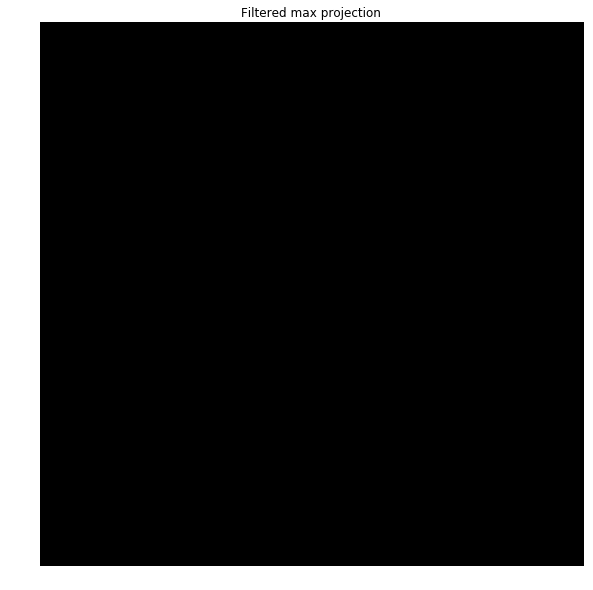

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(for_vis, cmap = 'gray', vmin=np.percentile(for_vis, 98), vmax=np.percentile(for_vis, 99.9))
plt.title('Filtered max projection')
plt.axis('off');

### Spot Finding

In [33]:
min_distance = 6
stringency = 0
min_obj_area = 6
max_obj_area = 600

# TODO this will go away once ImageStack.max_proj returns an ImageStack
# stack = ImageStack.from_numpy_array(np.expand_dims(np.expand_dims(np.expand_dims(mp, 0), 0), 0))

lmp = SpotFinder.LocalMaxPeakFinder(
    min_distance=min_distance,
    stringency=stringency,
    min_obj_area=min_obj_area,
    max_obj_area=max_obj_area
)
lmp_res = lmp.run(mp)

  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 99%|█████████▉| 99/100 [00:39<00:00,  2.31it/s]

Stopping early at threshold=1.0. Number of spots fell below: 3
Stopping early at threshold=1.0. Number of spots fell below: 3


IndexError: index 1 is out of bounds for axis 0 with size 1

### Spot finding QA

In [ ]:
lmp_res

In [ ]:
plt.hist(lmp_res.data[:,0,0], bins=20)
sns.despine(offset=2)
plt.yscale('log')
plt.xlabel('Intensity')
plt.ylabel('Number of spots');

In [ ]:
# mp = stack_hp_lap.max_proj(Indices.Z)[0,0,:,:]
mp = stack_hp_lap.max_proj(Indices.Z)
mp = mp.sel({Indices.CH: 0, Indices.R: 0}).xarray.squeeze()

plt.figure(figsize=(10,10))
plt.imshow(mp, cmap = 'gray', vmin=np.percentile(mp, 98), vmax=np.percentile(mp, 99.9))
plt.plot(lmp_res.x, lmp_res.y, 'or')
plt.axis('off');

## Compare to pySMFISH peak calls

In [ ]:
num_spots_simone = len(sp)
num_spots_starfish = len(lmp_res)

plt.figure(figsize=(10,10))
plt.plot(sp.x, -sp.y, 'o')
sns.despine(offset=20)
plt.plot(lmp_res.x, -lmp_res.y, 'x')

plt.legend(['Benchmark: {} spots'.format(num_spots_simone),
            'Starfish: {} spots'.format(num_spots_starfish)])
plt.title('osmFISH spot calls');

print("Starfish finds {} fewer spots".format(num_spots_simone-num_spots_starfish))